
#**Brain Tumours Segmentation using U-Nets**

This dataset includes three types of tumour.

The analysis requires graphical processing units, **so before you start, make sure that you are connected to a GPU runtime.**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Get brain tumour data

##Get brain tumor images
Download using the wget system command
Check the files have loaded and are of the right size (~1.5GB, ~760MB; 25KB)

In [ ]:
# REDACTED

Load image and mask data as numpy arrays. Check the data types are as expected.



In [ ]:
images = np.load('images.py')
masks = np.load('masks.py')
masks = masks.astype(np.float16)
labels = np.load('labels.py')
print(images.shape)
print(images.dtype)
print(masks.shape)
print(masks.dtype)
print(labels.shape)
print(labels.dtype)

(3064, 512, 512)
int16
(3064, 512, 512)
float16
(3064,)
int64


Define dictionary of tumour categories.

Plot the number of scans per tumour type.

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


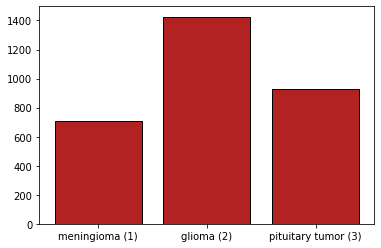

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'],\
        color='firebrick', edgecolor='black')

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Divide dataset by tumour class

In [ ]:
print(images.shape)

# meningioma_images = images[np.where(labels == 1)]
# meningioma_masks = masks[np.where(labels == 1)]
# print(meningioma_images.shape)

# glioma_images = images[np.where(labels == 2)]
# glioma_masks = masks[np.where(labels == 2)]
# print(glioma_images.shape)

# pituitary_images = images[np.where(labels == 3)]
# pituitary_masks = masks[np.where(labels == 3)]
# print(pituitary_images.shape)

(3064, 512, 512)


##Create training and test data
Need to randomly select a proportion of data for training and testing

In [ ]:
def train_test_split(image_data, mask_data, train_proportion):
    np.random.seed(38)
    train_proportion = train_proportion
    train_index = np.random.choice(image_data.shape[0], size = int(image_data.shape[0] * train_proportion), replace = False)
    print(str("Training set = ") + str("{:.0%}".format(train_proportion)) + str(", n = ") + str(len(train_index)))
    
    x_train = image_data[train_index, :, :]
    x_train = np.expand_dims(x_train, axis=3)

    y_train = mask_data[train_index, :, :]
    y_train = np.expand_dims(y_train, axis=3)

    x_test = np.delete(image_data, train_index, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = np.delete(mask_data, train_index, axis=0)
    y_test = np.expand_dims(y_test, axis=3)
    return x_train, y_train, x_test, y_test

Generate your training and test data. The inputs here are the images and corresponding mask file.<br>
You can set the proportion of data to be used for training; the remainder will be used for testing.

In [ ]:
# choose input data
input_images = images
input_masks = masks
# run train_test_split function
x_train, y_train, x_test, y_test = train_test_split(image_data = input_images, mask_data = input_masks, train_proportion = 0.8)

Training set = 80%, n = 2451


In [ ]:
print(y_train.shape)
print(x_test.shape)
print(x_test.dtype)
print(y_train.dtype)

(2451, 512, 512, 1)
(613, 512, 512, 1)
int16
float16


###Check that the data are properly specified
This will run on a random subject each time

In [ ]:
idx = random.randint(0,x_train.shape[0])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(np.squeeze(x_train[idx]), cmap='gray')
ax2.imshow(np.squeeze(y_train[idx]), cmap='gray')
ax1.title.set_text('X = Training image')
ax2.title.set_text('Y = Training mask')
plt.tight_layout()

Plot histogram/bar-plot of x_train (images) and y_train (masks)

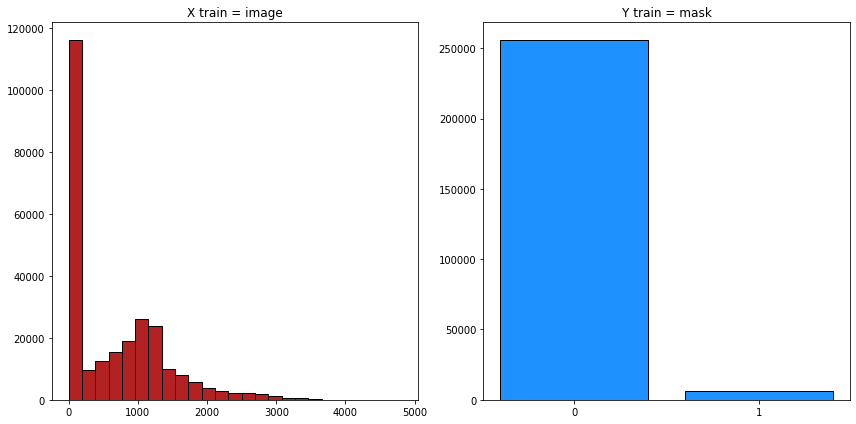

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(np.concatenate(x_train[idx]), bins=25, facecolor='firebrick', edgecolor='black')
ax2.bar(x=['0','1'], height=np.unique(y_train[idx], return_counts=True)[1], facecolor='dodgerblue', edgecolor='black')
ax1.title.set_text('X train = image')
ax2.title.set_text('Y train = mask')
plt.tight_layout()

##Custom performance metrics


Intersection over union (IoU), also known as the Jaccard Index. Area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.

In [ ]:
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_loss(y_true, y_pred):
    return 1-iou_coef(y_true, y_pred)

# Alternative implementation of the Jaccard Index
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


# Dice overlap coefficient. Double the sum of the intersection over the total size of the area of both regions.
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Focal loss. Requires Tensorflow Addons<br>
https://neptune.ai/blog/keras-loss-functions


In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 13.3MB/s 


##Define UNet architecture
#### The following elements can be included the architecture:
- 2D convolution with padded feature maps (for convenience in working out the sizes at different resolution levels)
- nonlinear activation
- pooling layer
- normalisation layer
- dropout

### Function to define convolutional blocks
Adds two convolutional layers with the parameters passed to it.


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, activ_func='relu', batchnorm = True, pad='same'):
    # first layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    # second layer
    block = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = pad)(input_tensor)
    if batchnorm:
        block = tf.keras.layers.BatchNormalization()(block)
    block = tf.keras.layers.Activation(activ_func)(block)
    
    return block

### Function to define UNet layers
Changing variables such as the number of filters, dropout rate and pool size for the max-pooling layer will influence prediction performance.

In [ ]:
def unet(input_img, n_filters=16, dropout=0.1, pool_size=(2,2), pad='same'):
  s = tf.keras.layers.Lambda(lambda x: x / 255)(input_img)
  # Contracting path
  c1 = conv2d_block(input_img, n_filters=n_filters)
  c1 = tf.keras.layers.Dropout(dropout)(c1)
  p1 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c1)
 
  c2 = conv2d_block(p1, n_filters=n_filters * 2)
  c2 = tf.keras.layers.Dropout(dropout)(c2)
  p2 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c2)
 
  c3 = conv2d_block(p2, n_filters=n_filters * 4)
  c3 = tf.keras.layers.Dropout(dropout)(c3)
  p3 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c3)
  
  c4 = conv2d_block(p3, n_filters=n_filters * 8)
  c4 = tf.keras.layers.Dropout(dropout)(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size = pool_size)(c4)
  
  c5 = conv2d_block(p4, n_filters=n_filters * 16)
  c5 = tf.keras.layers.Dropout(dropout)(c5)
    
  # Expanding path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=pad)(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = conv2d_block(c6, n_filters=n_filters * 8)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=pad)(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = conv2d_block(c7, n_filters=n_filters * 4)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=pad)(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = conv2d_block(c8, n_filters=n_filters * 2)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=pad)(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = conv2d_block(c9, n_filters=n_filters)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = tf.keras.models.Model(inputs=[input_img], outputs=[outputs])
  return model

##Generate model
Can set input dimensions, channels and other parameters, as well as chose the optimiser. Adam is commonly used for Unets.
The loss function for image segmentation can be binary cross-entropy, treating segmentation as a voxel classification problem. Alongside the loss function, other metrics can be reported to get a better idea of performance.

In [ ]:
IMG_WIDTH = x_train.shape[1]
IMG_HEIGHT = x_train.shape[2]
IMG_CHANNELS = 1
input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = unet(input_img, dropout=0.1, pool_size=(2,2), pad='same')
adam = tf.keras.optimizers.Adam(lr=0.001)
loss_func='binary_crossentropy'
## compile model
model.compile(optimizer=adam,
              loss=loss_func,            
              metrics=[iou_coef, dice_coef, 'accuracy'])

#Train model

Create checkpoints for logging model performance during training and define callbacks to enable early stopping or adaptively change the learning rate on a plateau in performance. Changing the patience argument will influence when early stopping happens.<br>
If you get out of memory errors (OOM), you can try reducing the batch size. Training will take longer, but should give similar results. Altering the early stopping criteria (e.g., min delta), the maximum number of epochs or even the optimiser's learning rate will reduce training time.
We save the best model (not necessarily the last one) for final testing.

In [ ]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
  tf.keras.callbacks.ModelCheckpoint('best_model_gliomas.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

**Fit model**<br>
Consider changing the training/validation split, the mini-batch size or the number of epochs and assess the impact this has on results.

Epoch 1/50
123/123 [==============================] - 52s 267ms/step - loss: 0.5021 - iou_coef: 0.0130 - dice_coef: 0.0260 - accuracy: 0.8042 - val_loss: 0.1918 - val_iou_coef: 0.0136 - val_dice_coef: 0.0283 - val_accuracy: 0.9821

Epoch 00001: val_loss improved from inf to 0.19180, saving model to best_model_gliomas.h5
Epoch 2/50
123/123 [==============================] - 30s 245ms/step - loss: 0.1774 - iou_coef: 0.0148 - dice_coef: 0.0310 - accuracy: 0.9827 - val_loss: 0.1231 - val_iou_coef: 0.0138 - val_dice_coef: 0.0298 - val_accuracy: 0.9836

Epoch 00002: val_loss improved from 0.19180 to 0.12314, saving model to best_model_gliomas.h5
Epoch 3/50
123/123 [==============================] - 30s 245ms/step - loss: 0.1166 - iou_coef: 0.0181 - dice_coef: 0.0389 - accuracy: 0.9836 - val_loss: 0.0873 - val_iou_coef: 0.0150 - val_dice_coef: 0.0332 - val_accuracy: 0.9836

Epoch 00003: val_loss improved from 0.12314 to 0.08730, saving model to best_model_gliomas.h5
Epoch 4/50
123/123 [======

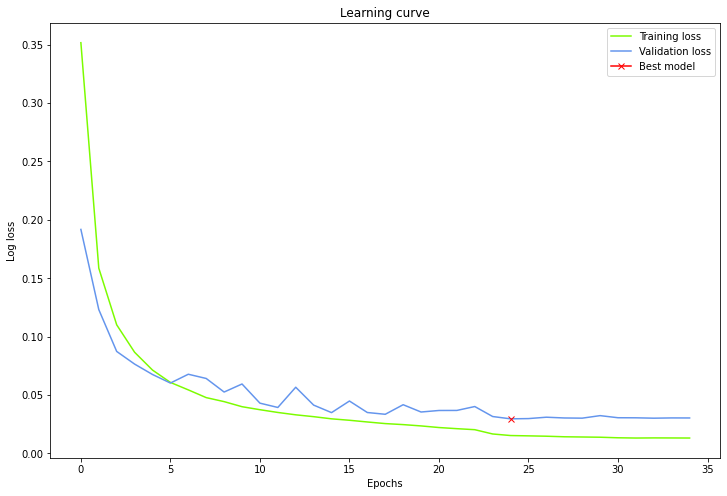

In [ ]:
results = model.fit(x=x_train, y=y_train,
                    validation_split=0.2,
                    batch_size=16,
                    epochs=50,
                    callbacks=callbacks)


plt.figure(figsize=(12, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="Training loss", color='lawngreen')
plt.plot(results.history["val_loss"], label="Validation loss", color='cornflowerblue')
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();


print("learning rate = "  + str(K.eval(model.optimizer.lr)))

#Evaluate performance

Load checkpoint data and get performance on test data using training weights

In [ ]:
model.load_weights('best_model_gliomas.h5')
model.evaluate(x_test,  y_test, verbose=2)


20/20 - 3s - loss: 0.0294 - iou_coef: 0.4356 - dice_coef: 0.6207 - accuracy: 0.9905


[0.029400350525975227,
 0.43558064103126526,
 0.6207388639450073,
 0.9905139803886414]

##Apply to test data
This step generates the predicted mask images in 2D

In [ ]:
predict = model.predict(x_test, verbose=1)
predict = (predict > 0.5).astype(np.int8)

20/20 [==============================] - 19s 97ms/step


##Calculate Dice overlap coefficient per subject
As above Dice is 2 * the area of overlap divided by the total number of pixels in both images. This function can be used to test the overlap with a single predicted mask.

In [ ]:
def get_dice(idx):
  seg = np.squeeze(predict[idx])
  gt = np.squeeze(y_test[idx])
  dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
  return dice


dices = []
for i in range(x_test.shape[0]):
  dices.append(get_dice(i))

print('mean = ' + '{:.3f}'.format(np.mean(dices)))
print('median = ' + '{:.3f}'.format(np.median(dices)))
print('SD = ' + '{:.3f}'.format(np.std(dices)))

Histogram to show distribution of Dice scores

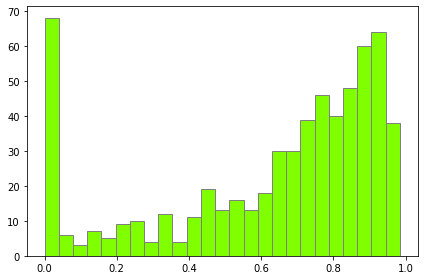

In [ ]:
dices = []
for i in range(x_test.shape[0]):
  dices.append(get_dice(i))
plt.hist(dices, bins='sqrt', facecolor='chartreuse', edgecolor='grey')
plt.tight_layout()

Find the subject with the highest Dice overlap

In [ ]:
maxDice = np.where(dices == np.amax(dices))
print('ID = ' + str(maxDice[0]))
print('{:.2f}'.format(get_dice(maxDice[0])))

ID = [476]
0.98


Visualise the predictions for the subject with highest overlap

In [ ]:
idx = maxDice[0]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes[0,0].imshow(np.squeeze(predict[idx]), cmap='gray')
axes[0,1].imshow(np.squeeze(y_test[idx]), cmap='gray')
axes[1,0].imshow(np.squeeze(x_test[idx]), cmap='gray')
axes[1,1].imshow(np.squeeze(x_test[idx]), cmap = 'gray')
axes[1,1].imshow(np.ma.masked_where(np.squeeze(predict[idx]) == False, np.squeeze(predict[idx])), alpha=0.4, cmap = 'Set1')
axes[0,0].title.set_text('Predicted label')
axes[0,1].title.set_text('True label')
axes[1,0].title.set_text('Brain image')
axes[1,1].title.set_text('Overlay predicted label')
plt.tight_layout()

Bar plot to illustrate the imbalance in 0s and 1s in the image.

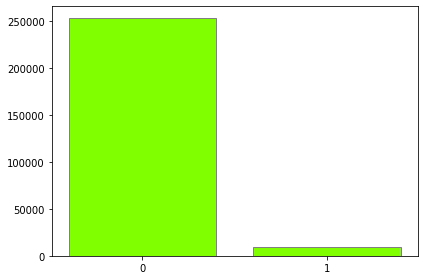

In [ ]:
idx = maxDice[0]
plt.figure(figsize=(6,4))
plt.bar(x=['0','1'], height=np.unique(predict[idx], return_counts=True)[1], facecolor='chartreuse', edgecolor='grey')
plt.tight_layout()

## Correlations between mask volumes

Function to get the size (i.e., number of pixels) for the true mask and predicted mask

In [ ]:
def get_mask_sizes(idx):
    true_mask_size = np.count_nonzero(y_test[idx])
    predicted_mask_size = np.count_nonzero(predict[idx])
    return true_mask_size, predicted_mask_size

Run on example subject

In [ ]:
get_mask_sizes(idx = maxDice[0])

(8936, 8965)

Loop through all the test data

In [ ]:
true_masks = [get_mask_sizes(x)[0] for x in range(y_test.shape[0])]
predicted_masks = [get_mask_sizes(x)[1] for x in range(y_test.shape[0])]

Correlation between the true mask sizes and predicted mask sizes

In [ ]:
print('{:.3f}'.format(np.corrcoef(true_masks, predicted_masks)[0,1]))

0.728


Scatterplot of the true mask sizes and predicted mask sizes

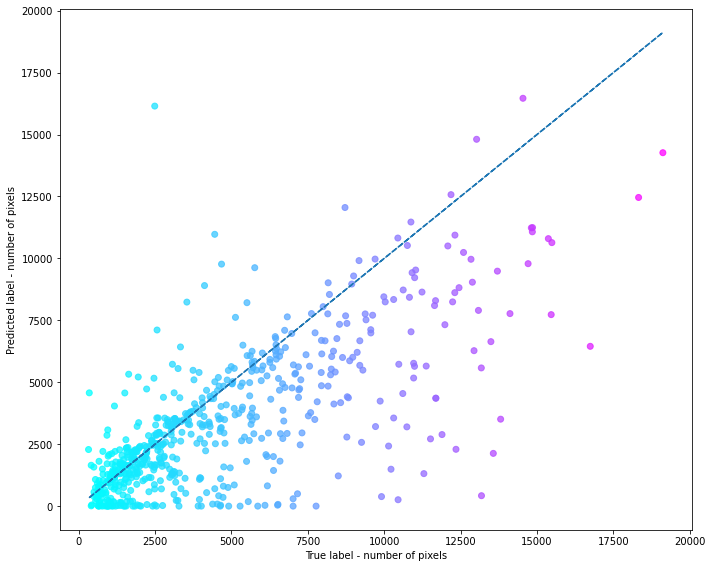

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(true_masks,true_masks, linestyle='dashed')
plt.scatter(true_masks, predicted_masks, c=true_masks, alpha = 0.75, cmap = 'cool')
plt.xlabel("True label - number of pixels")
plt.ylabel("Predicted label - number of pixels")
plt.tight_layout()

#Data augmentation
Create synthetic data based on the real data to augment the training process.<br>
This example data augmentation uses rotations. You can change the subject 'idx' to look at different brains.

## Try more augmentations

In [ ]:
idx = 3
samples = np.expand_dims(np.expand_dims(images[idx,:,:],-1),0)

datagen = ImageDataGenerator(width_shift_range=[-20,20],
                             height_shift_range=[-10,10],
                             horizontal_flip=True,
                             rotation_range=90,
                             brightness_range=[0.1,2],
                             zoom_range=0.2)
it = datagen.flow(samples, batch_size=1)

Now plot them

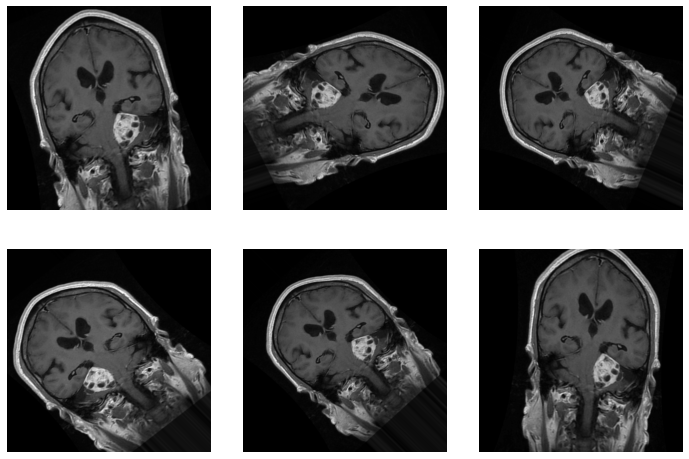

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(6):
	plt.subplot(330 + 1 + i,)
	batch = it.next()
	image = batch[0]
	plt.imshow(np.squeeze(image,-1), cmap='gray')

plt.tight_layout()

for ax in fig.axes:
    ax.axis("off")

## Train a model with augmentation.
Need to apply identical augmentations to image-mask pairs (or the masks won't match the images!). Also need to manually split the training and validation data.

### Augumentation 1

In [ ]:
# we create two instances with the same arguments 
# data_gen_args = dict(rotation_range=90) 
data_gen_args = dict(width_shift_range=[-20,20],
                    height_shift_range=[-20,20],
                    horizontal_flip=True,
                    rotation_range=45)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# split data into training and validation
x_train_aug, y_train_aug, x_val_aug, y_val_aug = train_test_split(image_data = x_train, mask_data = y_train, train_proportion = 0.8)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# image_datagen.fit(np.expand_dims(images,3), augment=True, seed=seed)
# mask_datagen.fit(np.expand_dims(masks,3), augment=True, seed=seed)

image_generator = image_datagen.flow(np.squeeze(x_train_aug, axis=3), seed=seed)
mask_generator = mask_datagen.flow(np.squeeze(y_train_aug, axis=3), seed=seed)

validation_image_generator = image_datagen.flow(np.squeeze(x_val_aug, axis=3), seed=seed)
validation_mask_generator = mask_datagen.flow(np.squeeze(y_val_aug, axis=3), seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)        

Training set = 80%, n = 1960


Epoch 1/50
50/50 [==============================] - 69s 1s/step - loss: 0.7275 - iou_coef: 0.0153 - dice_coef: 0.0305 - accuracy: 0.5987 - val_loss: 3.7956 - val_iou_coef: 0.0145 - val_dice_coef: 0.0297 - val_accuracy: 0.4662

Epoch 00001: val_loss improved from inf to 3.79555, saving model to best_model_aug1.h5
Epoch 2/50
50/50 [==============================] - 64s 1s/step - loss: 0.3385 - iou_coef: 0.0123 - dice_coef: 0.0246 - accuracy: 0.9815 - val_loss: 0.2494 - val_iou_coef: 0.0143 - val_dice_coef: 0.0293 - val_accuracy: 0.9802

Epoch 00002: val_loss improved from 3.79555 to 0.24938, saving model to best_model_aug1.h5
Epoch 3/50
50/50 [==============================] - 65s 1s/step - loss: 0.2375 - iou_coef: 0.0127 - dice_coef: 0.0264 - accuracy: 0.9826 - val_loss: 0.1952 - val_iou_coef: 0.0093 - val_dice_coef: 0.0198 - val_accuracy: 0.9828

Epoch 00003: val_loss improved from 0.24938 to 0.19515, saving model to best_model_aug1.h5
Epoch 4/50
50/50 [==============================] 

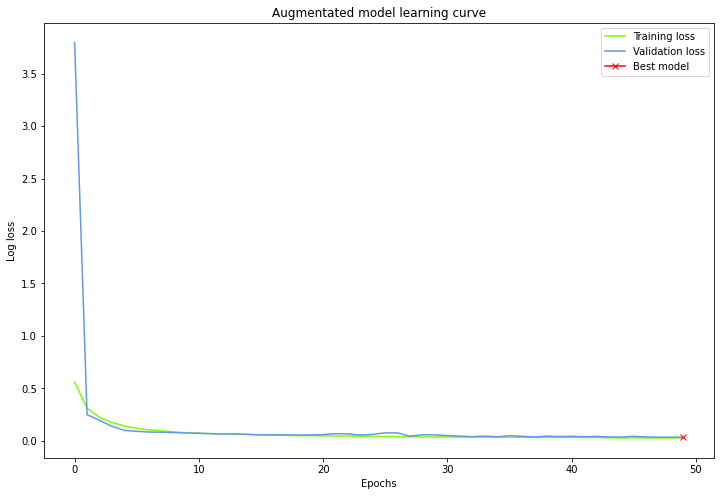

In [ ]:
aug_callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
  tf.keras.callbacks.ModelCheckpoint('best_model_aug1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
aug_results = model.fit(x=train_generator,
                    batch_size=16,
                    epochs=50,
                    callbacks=aug_callbacks,
                    validation_data=validation_generator,
                    steps_per_epoch=50,
                    validation_steps=10,
                    )

plt.figure(figsize=(12, 8))
plt.title("Augmentated model learning curve")
plt.plot(aug_results.history["loss"], label="Training loss", color='lawngreen')
plt.plot(aug_results.history["val_loss"], label="Validation loss", color='cornflowerblue')
plt.plot(np.argmin(aug_results.history["val_loss"]), np.min(aug_results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();

In [ ]:
# Standard augumentation with just rotation by 90*
model.load_weights('best_model_aug1.h5')
model.evaluate(x_test,  y_test, verbose=2)

20/20 - 2s - loss: 0.0316 - iou_coef: 0.3381 - dice_coef: 0.5254 - accuracy: 0.9893


[0.03163814917206764,
 0.3381372094154358,
 0.5254496335983276,
 0.9892659783363342]

### Augumentation 2

In [ ]:
# we create two instances with the same arguments 
# data_gen_args = dict(rotation_range=90) 
data_gen_args = dict(width_shift_range=[-20,20],
                     height_shift_range=[-10,10],
                     horizontal_flip=True,
                     rotation_range=90)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# split data into training and validation
x_train_aug, y_train_aug, x_val_aug, y_val_aug = train_test_split(image_data = x_train, mask_data = y_train, train_proportion = 0.8)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# image_datagen.fit(np.expand_dims(images,3), augment=True, seed=seed)
# mask_datagen.fit(np.expand_dims(masks,3), augment=True, seed=seed)

image_generator = image_datagen.flow(np.squeeze(x_train_aug, axis=3), seed=seed)
mask_generator = mask_datagen.flow(np.squeeze(y_train_aug, axis=3), seed=seed)

validation_image_generator = image_datagen.flow(np.squeeze(x_val_aug, axis=3), seed=seed)
validation_mask_generator = mask_datagen.flow(np.squeeze(y_val_aug, axis=3), seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)        

Training set = 80%, n = 1960


Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 0.2606 - iou_coef: 0.1224 - dice_coef: 0.2161 - accuracy: 0.9467 - val_loss: 0.5897 - val_iou_coef: 0.0606 - val_dice_coef: 0.1127 - val_accuracy: 0.8630

Epoch 00001: val_loss improved from inf to 0.58968, saving model to best_model_aug2.h5
Epoch 2/50
50/50 [==============================] - 64s 1s/step - loss: 0.2629 - iou_coef: 0.1220 - dice_coef: 0.2160 - accuracy: 0.9466 - val_loss: 0.3444 - val_iou_coef: 0.0894 - val_dice_coef: 0.1609 - val_accuracy: 0.9273

Epoch 00002: val_loss improved from 0.58968 to 0.34442, saving model to best_model_aug2.h5
Epoch 3/50
50/50 [==============================] - 64s 1s/step - loss: 0.2585 - iou_coef: 0.1216 - dice_coef: 0.2171 - accuracy: 0.9478 - val_loss: 0.2626 - val_iou_coef: 0.1083 - val_dice_coef: 0.1947 - val_accuracy: 0.9487

Epoch 00003: val_loss improved from 0.34442 to 0.26258, saving model to best_model_aug2.h5
Epoch 4/50
50/50 [==============================] 

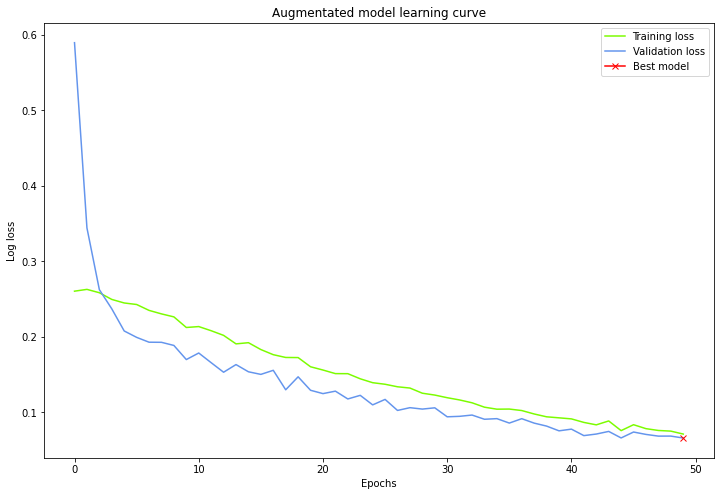

In [ ]:
# New Augumentation with settings:
  # width_shift_range=[-20,20],
  # height_shift_range=[-10,10],
  # horizontal_flip=True,
  # rotation_range=90

aug_callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
  tf.keras.callbacks.ModelCheckpoint('best_model_aug2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
aug_results = model.fit(x=train_generator,
                    batch_size=16,
                    epochs=50,
                    callbacks=aug_callbacks,
                    validation_data=validation_generator,
                    steps_per_epoch=50,
                    validation_steps=10,
                    )

plt.figure(figsize=(12, 8))
plt.title("Augmentated model learning curve")
plt.plot(aug_results.history["loss"], label="Training loss", color='lawngreen')
plt.plot(aug_results.history["val_loss"], label="Validation loss", color='cornflowerblue')
plt.plot(np.argmin(aug_results.history["val_loss"]), np.min(aug_results.history["val_loss"]),
         marker="x", color="red", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Log loss")
plt.legend();

In [ ]:
model.load_weights('best_model_aug2.h5')
model.evaluate(x_test,  y_test, verbose=2)


20/20 - 2s - loss: 0.0462 - iou_coef: 0.3575 - dice_coef: 0.5488 - accuracy: 0.9889


[0.046203549951314926,
 0.3574655055999756,
 0.5487930178642273,
 0.9888659119606018]